In [26]:
import numpy as np
import dask.array as da
import xarray as xr
import pandas as pd
from PIL import Image
import random
from dask import delayed, compute
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt

class ImageProcessor:
    """Image generation class
    """    
    
    def __init__(self, 
                num_to_generate,
                tiff_path, 
                dark_noise_path, 
                canvas_size = (64, 64), 
                max_electron_hits = 410):
        
        """initializes the ImageProcessor class

        Args:
            num_to_generate (int): Number of images to generate
            tiff_path (filepath): Location of the tiff file that contains the electron hits
            dark_noise_path (filepath): path to the noisy data
            canvas_size (tuple, optional): Size of the canvas to place the images on. Defaults to (64, 64).
            max_electron_hits (int, optional): Maximum number of electron hits to place on the canvas. Defaults to 410.
        """        
        
        self.tiff_path = tiff_path
        self.dark_noise_path = dark_noise_path
        self.canvas_size = canvas_size
        self.num_to_generate = num_to_generate
        self.max_electron_hits = max_electron_hits
        
        # loads the images from the tiff file
        self.images = self.load_images_from_tiff(tiff_path)
        self.dark_noise_images = self.load_images_from_tiff(dark_noise_path)
        
        # creates a dark stack of the same size as the canvas
        self.dark_noise = self.dark_stack(self.canvas_size[0])
        

    def load_images_from_tiff(self, tiff_path):
        """loads the images from a tiff file

        Args:
            tiff_path (path): path to the tiff file

        Returns:
            list: list of images
        """        
        with Image.open(tiff_path) as img:
            images = []
            for i in range(img.n_frames):
                img.seek(i)
                images.append(np.array(img))
            return images
        
    def noisy(self, noise_typ, image): 
        """Adds noise to the images
        
        Args:
            noise_typ (str): Type of noise to add
            image (numpy array): Image to add noise to
        
        Returns:
            numpy array: Noisy image
        """
        if noise_typ == "gauss":
            row, col = image.shape
            mean = 0
            var = 0.0001
            sigma = var**0.5
            threshold = 8
            gauss = np.random.normal(mean, sigma, (row, col))
            tnoisy = image + gauss

            tnoisy[tnoisy < threshold] = 0
            noisy = np.round(tnoisy)
            return noisy

    def deadcorr(self, image):
        '''
        This function corrects the dead pixel within the dark reference frame.
        Works for current dead pixel correction, interpolating from near positions.
        
        Args:
            image (numpy array): Image to correct
        '''
        
        #TODO: Why is this hard coded?
        temp = image.copy()
        temp[:, 248] = 0.5 * temp[:, 247] + 0.5 * temp[:, 246]
        return temp

    def dark_stack(self, imgsize):
        '''
        Function that creates a dark stack of the same size as the canvas.
        
        Args:
            imgsize (int): Size of the images in the stack
        '''
        
        dark_noise_stack_corrected = [self.deadcorr(image) for image in self.dark_noise_images]
        # Crop images to the specified size around the center
        dark_noise_stack_cropped = [image[512:512+imgsize, 512:512+imgsize] for image in dark_noise_stack_corrected]
        return dark_noise_stack_cropped

    def place_image_on_canvas(self, positions):
        '''
        Function that places the electron hits on the canvas.
        
        Args:
            positions (int): Number of electron hits to place on the canvas
        '''
        
        # Create a blank canvas
        canvas = np.zeros(self.canvas_size, dtype=np.uint8)

        # Get the dimensions of the images of electron higs
        height, width = self.images[0].shape
        
        # Get the maximum x and y values to place the images
        max_x = self.canvas_size[1] - width
        max_y = self.canvas_size[0] - height
        
        # Initialize lists to store the bounding boxes and centers of the electron hits
        bounding_boxes = []
        centers = []
        index_ = []
        
        # loop through the number of electron hits to place on the canvas
        for _ in range(positions):
            
            # Get a random position to place the image
            # min is set to the width and height to avoid placing the image on the edge of the canvas
            # max is set to the maximum x and y values this already has the width and height subtracted
            x = random.randint(width, max_x)
            y = random.randint(height, max_y)
            
            # Get a random image to place on the canvas
            index = random.randint(0, len(self.images) - 1)  # Get a random index
            hit = self.images[index]  # Access the element using the random index

            # Place the image on the canvas
            canvas[y:y+height, x:x+width] = hit
            
            # Store the bounding box and center of the electron hit
            bounding_boxes.append((x, y, x+width, y+height))
            
            # Store the center of the electron hit
            centers.append((x + width / 2, y + height / 2))
            
            # Store the index of the electron hit used
            index_.append(index)
            
            
        # gaussian noise
        canvas = self.noisy('gauss', canvas)
        
        # selects a random integer from the dark stack
        noise_int = np.random.randint(len(self.dark_noise))
        
        # adds the dark noise to the canvas
        canvas = canvas + self.dark_noise[noise_int]
            
        return (canvas, bounding_boxes, centers, index_, positions, noise_int)

    def generate_multiple_images(self):
        '''
        Function that generates multiple images
            
        '''
        
        # Initialize a list to store the results
        results = []

        # Loop through the number of images to generate
        for i in tqdm(range(self.num_to_generate), desc="Generating images"):
            positions = random.randint(1, self.max_electron_hits)
            results.append(self.place_image_on_canvas(positions))

        return results
    
    def save_to_H5(self, data, filename):
        
        with h5py.File(filename, 'w') as f:
            for i, item in enumerate(data):
                grp = f.create_group(f'image_{i}')
                grp.create_dataset('image', data=item[0])
                grp.create_dataset('bounding_boxes', data=item[1])
                grp.create_dataset('center_positions', data=item[2])
                grp.attrs['index'] = item[3]
                grp.attrs['position'] = item[4]
                grp.attrs['noise'] = item[5]
                
    def read_from_H5(self, filename, image_number, verbose=False):
        
        with h5py.File(filename, 'r') as file:
            # Access the group and dataset
            data = file[f'image_{image_number}/image'][...]  # Using [...] reads the entire dataset
            bounding_boxes = file[f'image_{image_number}/bounding_boxes'][...]
            center_positions = file[f'image_{image_number}/center_positions'][...]

            # Access attributes
            index = file[f'image_{image_number}'].attrs['index']
            position = file[f'image_{image_number}'].attrs['position']
            noise = file[f'image_{image_number}'].attrs['noise']

            if verbose:
                print("Bounding boxes:", bounding_boxes)
                print("Center positions:", center_positions)
                print("Index:", index)
                print("Position:", position)
                print("Noise:", noise)

                # Display the image using matplotlib if it's an image data
                plt.imshow(data, cmap='gray')
                plt.show()
                
            return data, bounding_boxes, center_positions, index, position, noise

# Example usage
tiff_path = './data/200kV_98000electron.tif'
dark_noise_path = './data/1000fps_fullRolling.tif'

processor = ImageProcessor(1000, tiff_path, dark_noise_path)

data = processor.generate_multiple_images()

processor.save_to_H5(data, 'images.h5')



Generating images: 100%|██████████| 1000/1000 [00:01<00:00, 520.70it/s]


Bounding boxes: [[26 44 45 63]
 [43 19 62 38]
 [27 36 46 55]
 [44 29 63 48]
 [26 29 45 48]
 [45 37 64 56]
 [43 35 62 54]
 [35 38 54 57]
 [29 41 48 60]
 [24 45 43 64]
 [36 24 55 43]
 [29 44 48 63]
 [24 33 43 52]
 [37 28 56 47]
 [33 19 52 38]
 [34 23 53 42]
 [40 20 59 39]
 [45 29 64 48]
 [36 44 55 63]
 [23 29 42 48]
 [31 28 50 47]
 [42 44 61 63]
 [44 24 63 43]
 [41 28 60 47]
 [35 44 54 63]
 [36 23 55 42]
 [37 25 56 44]
 [31 38 50 57]
 [37 24 56 43]
 [33 33 52 52]
 [40 45 59 64]
 [41 29 60 48]
 [29 32 48 51]
 [37 44 56 63]
 [41 44 60 63]
 [24 33 43 52]
 [43 20 62 39]
 [23 37 42 56]
 [19 23 38 42]
 [45 21 64 40]
 [30 30 49 49]
 [32 38 51 57]
 [45 34 64 53]
 [24 43 43 62]
 [36 21 55 40]
 [31 26 50 45]
 [23 36 42 55]
 [39 20 58 39]
 [33 43 52 62]
 [44 39 63 58]
 [39 30 58 49]
 [43 24 62 43]
 [37 41 56 60]
 [37 27 56 46]
 [22 40 41 59]
 [30 24 49 43]
 [42 32 61 51]
 [34 22 53 41]
 [21 36 40 55]
 [36 45 55 64]
 [37 43 56 62]
 [29 33 48 52]
 [34 30 53 49]
 [29 36 48 55]
 [35 33 54 52]
 [40 19 5

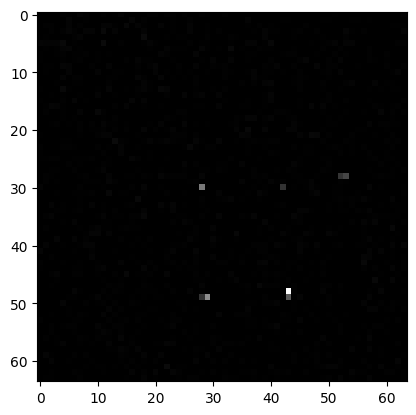

In [28]:
out = processor.read_from_H5('images.h5', 10, verbose=True)


In [18]:
imageXarray

[(array([[2., 4., 0., ..., 3., 0., 1.],
         [0., 0., 0., ..., 0., 0., 0.],
         [3., 0., 3., ..., 1., 0., 1.],
         ...,
         [0., 2., 1., ..., 0., 2., 0.],
         [1., 0., 0., ..., 2., 2., 0.],
         [0., 0., 0., ..., 1., 0., 0.]]),
  [(20, 36, 39, 55),
   (36, 37, 55, 56),
   (23, 34, 42, 53),
   (27, 31, 46, 50),
   (22, 38, 41, 57),
   (23, 40, 42, 59),
   (19, 24, 38, 43),
   (40, 45, 59, 64),
   (41, 29, 60, 48),
   (26, 40, 45, 59),
   (29, 32, 48, 51),
   (33, 23, 52, 42),
   (40, 33, 59, 52),
   (19, 40, 38, 59),
   (29, 29, 48, 48),
   (24, 19, 43, 38),
   (45, 33, 64, 52),
   (30, 25, 49, 44),
   (37, 45, 56, 64),
   (21, 42, 40, 61),
   (21, 23, 40, 42),
   (26, 42, 45, 61),
   (24, 27, 43, 46),
   (19, 40, 38, 59),
   (19, 45, 38, 64),
   (23, 19, 42, 38),
   (42, 29, 61, 48),
   (35, 22, 54, 41),
   (29, 43, 48, 62),
   (42, 31, 61, 50),
   (45, 38, 64, 57),
   (21, 40, 40, 59),
   (40, 23, 59, 42),
   (20, 31, 39, 50),
   (26, 37, 45, 56),
   (40, 4

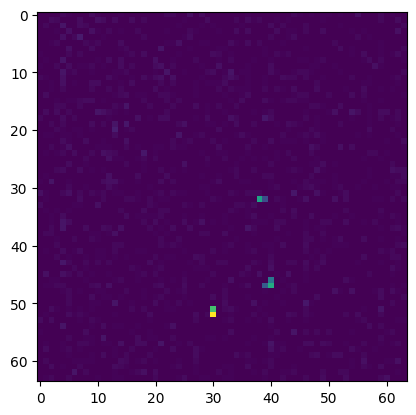

In [13]:
import matplotlib.pyplot as plt
plt.imshow(imageXarray[80][0])

In [1]:
import numpy as np
import xarray as xr

# Create synthetic data for demonstration
num_images = 100
image_height = 256
image_width = 256

# Dummy images data
images = np.random.rand(num_images, image_height, image_width)

# Dummy annotations data (bounding boxes)
# Assuming a list of bounding boxes for each image
annotations = [np.random.rand(np.random.randint(1, 5), 4) for _ in range(num_images)]

# Create Xarray DataArray for images
images_da = xr.DataArray(images, dims=('image_index', 'y', 'x'))

# Create Xarray DataArray for annotations
annotations_da = xr.DataArray(annotations, dims=('image_index', 'bbox_index', 'bbox_values'))

# Define coordinates
image_coords = np.arange(num_images)
images_da.coords['image_index'] = image_coords
annotations_da.coords['image_index'] = image_coords

# Combine both DataArrays into a single Dataset
dataset = xr.Dataset({'images': images_da, 'annotations': annotations_da})

# Optionally, you can add metadata to the dataset
dataset.attrs['description'] = 'Dataset for YOLO object detection'

# Save the dataset to a NetCDF file
dataset.to_netcdf('yolo_dataset.nc')


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

In [6]:
canvas_da.attrs['bounding_boxes']

NameError: name 'canvas_da' is not defined

<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

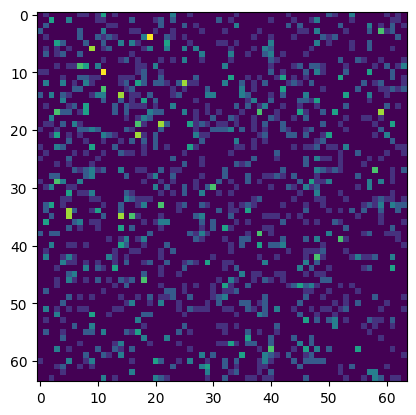

In [41]:
import matplotlib.pyplot as plt

plt.imshow(dark_stack[0])
plt.colorbar

## Model Architecture

In [ ]:
from typing import List

import torch
import torch.nn.functional as F
from torch import nn
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.rpn import RPNHead
from torchvision.ops import MultiScaleRoIAlign

class FCNBackbone(nn.Sequential):
    def __init__(self,
                 kernel: int = 3):
        super(FCNBackbone, self).__init__()
        self.channel2one = channellayer()
        self.kernel = kernel
        if self.kernel == 3:
            self.fcov = TinySegResNet_ori()
        elif self.kernel == 1:
            self.fcov = TinySegResNet()
        else:
            raise ValueError("use kernel = 3 or 1")

        features: List[nn.Module] = [self.channel2one] + list(self.fcov.c1.block.children())[:1] + list(
            self.fcov.bn.res_module[0].children())[:3]

        # make it nn.Sequential
        self.features = nn.Sequential(*features)

    def forward(self, x):
        x = self.channel2one(x)
        x = self.fcov(x)
        return x

def faster_rcnn_fcn(kernel, pretrained, num_classes, weights_path, setting_dict):
    """
    Constructs a Mask R-CNN model with a ResNet-50 backbone.

    Arguments:
        kernel(int): 3 or 1 for the cov layers in TinySegNet.
        pretrained (bool): If True, returns a model with pre-trained feature extraction layer.
        num_classes (int): number of classes (including the background).
        weights_path(directory str): the source model path for the feature extraction layers
        setting_dict: dict of all the model parameters

    """

    backbone = FCNBackbone(kernel=kernel)

    if pretrained:
        model_state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
        backbone.fcov.load_state_dict(model_state_dict['state_dict'])

    backbone = backbone.features

    stage_indices = [1, 2, 4]  # the three conv layers with original resolution
    num_stages = len(stage_indices)

    backbone.out_channels = 64
    returned_layers = [0, 1, 2]
    assert min(returned_layers) >= 0 and max(returned_layers) < num_stages
    return_layers = {f'{stage_indices[k]}': str(v) for v, k in enumerate(returned_layers)}
    in_channels_list = [backbone[stage_indices[i]].out_channels for i in returned_layers]

    backboneFPN = BackboneWithFPN(backbone, return_layers, in_channels_list, backbone.out_channels, extra_blocks=None)

    # change the padding model of cov layers in backboneFPN
    for layer in backboneFPN.fpn.inner_blocks:
        list(layer.children())[0].padding_mode = 'circular'
    for layer in backboneFPN.fpn.layer_blocks:
        list(layer.children())[0].padding_mode = 'circular'

    anchor_generator = AnchorGenerator(sizes=((1, 2, 4),) * 4, aspect_ratios=((0.5, 1, 2),) * 4, stride_multiplier=1)
    box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "pool"], output_size=5, sampling_ratio=4,
                                      canonical_scale=64, canonical_level=0)
    rpn_head = RPNHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0])

    resolution = box_roi_pool.output_size[0]
    representation_size = 128
    box_head = TwoMLPHead(backbone.out_channels * resolution ** 2, representation_size)  # (64*7^2, 1024)
    box_predictor = FastRCNNPredictor(representation_size, 2)

    # num_classes = none since it is already defined in box_predictor
    model = FasterRCNN(backbone=backboneFPN, num_classes=None,
                       rpn_anchor_generator=anchor_generator, rpn_head=rpn_head,
                       box_head=box_head, box_roi_pool=box_roi_pool, box_predictor=box_predictor,
                       **setting_dict)

    return model

# Data Preparation

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os

## load data

In [5]:
# Load the image stack of single event
raw = Image.open('./data/200kV_98000electron.tif')

# dark noise added from a exp dark frame
dark = Image.open()

In [6]:
from PIL import Image
import numpy as np
import xarray as xr

def tiff_to_xarray(image_path):
    with Image.open(image_path) as img:
        frames = []
        frame_count = 0
        try:
            while True:
                img.seek(frame_count)
                frames.append(np.array(img))
                frame_count += 1
        except EOFError:
            pass
        
    # Convert the list of frames to a numpy array
    frames_array = np.stack(frames, axis=0)

    # Create xarray DataArray
    data_array = xr.DataArray(
        frames_array,
        dims=["frame", "y", "x"],
        coords={"frame": np.arange(frames_array.shape[0])}
    )

    return data_array

In [7]:
# Load the image stack of single event
raw = tiff_to_xarray('./data/200kV_98000electron.tif')

In [21]:
imgsize = 64
sparsity = .1
max_count = 410

# gets the number of frames in the stack
w = raw['frame'].shape[0]

wh = int((w-1)/2)

# should just have a max value of electrons
count = np.random.randint(0,max_count)

posx = np.random.randint(0, imgsize, size=count)
posy = np.random.randint(0, imgsize, size=count)

# should make a vector that tracks if a spot is there.
# groundtruth = np.zeros((imgsize,imgsize))
# for i in range(len(posx)):
#     groundtruth[posx[i],posy[i]] += 1

TypeError: object of type 'TiffImageFile' has no len()

In [ ]:
# def randomtile(rawimagestack, sparsity, returnBoxMask = False, imgsize= 64):
#   '''
#   This function create images with random electron event distribution.
#   sparsity: # e-/px
#   imgsize: the size of output images.
#   '''
#   rawimagestack.seek(0)
#   w = np.asarray(rawimagestack).shape[0]
#   wh = int((w-1)/2)

#   count = int(np.ceil(imgsize*imgsize*sparsity))# number of electrons in a image
#   #print('Electons: ', count)
#   posx = np.random.randint(0,imgsize,size=count)
#   posy = np.random.randint(0,imgsize,size=count)

  # groundtruth = np.zeros((imgsize,imgsize))
  # for i in range(len(posx)):
  #   groundtruth[posx[i],posy[i]] += 1

  tileimage = np.zeros((imgsize+w-1,imgsize+w-1))
  # masks = np.zeros((len(posx), 15,15))
  boxes = np.zeros((len(posx), 4))

  for patch in range(len(posx)):
    index = random.randrange(0, 98000, 1) # number of image in the rawstack!!
    rawimagestack.seek(index)
    rawdata = np.asarray(rawimagestack)
    while rawdata.max()<=20:
      index = random.randrange(0, 98000, 1) # number of image in the rawstack!!
      rawimagestack.seek(index)
      rawdata = np.asarray(rawimagestack)

    rawdata = np.clip(rawdata, a_min=0, a_max = None)

    tileimage[posx[patch]:posx[patch]+w, posy[patch]:posy[patch]+w] = tileimage[posx[patch]:posx[patch]+w, posy[patch]:posy[patch]+w] + rawdata
    if returnBoxMask==True:
      #masks[patch][posx[patch]:posx[patch]+w, posy[patch]:posy[patch]+w] = rawdata>20  # threshold is set to 20.
      x, y = np.where(rawdata>20)
      # masks[patch][:(1+x.max()-x.min()), :(1+y.max()-y.min())] = rawdata[x.min():(x.max()+1), y.min():(y.max()+1)]>0
      boxes[patch] = (x.min()+posx[patch]-wh, y.min()+posy[patch]-wh,
                      x.max()+posx[patch]-wh, y.max()+posy[patch]-wh)

  if returnBoxMask==True:
      return groundtruth, tileimage[wh:imgsize+wh,wh:imgsize+wh],boxes
  else:
    return groundtruth, tileimage[wh:imgsize+wh,wh:imgsize+wh]

In [ ]:
def generate_images(filenumber, image_size):
    

# Random tile for training data generation

In [ ]:


# filenumber = 0
# imgsize = 64 ########
# for sparsity in np.linspace(0, 0.1,51):

#   # slist = np.linspace(sparsity, sparsity + 0.002, 11)[1:]
#   # repeat = 20 ######### defines how many images will be generated within this sparisity range
#   truth_all = np.zeros((10,repeat,imgsize,imgsize))
#   tiled_all = np.zeros((10,repeat,imgsize,imgsize))

#   imgfiles = []
#   boxfiles = []

  # # dark noise added from a exp dark frame
  # dark = Image.open('/content/drive/MyDrive/CNN e-detect for Celeritas/Black noise/1000fps_fullRolling.tif')

  for i in range(len(slist)):
    for rp in range(repeat):
      _, img, boxes = randomtile(rawimagestack = raw, sparsity = slist[i], returnBoxMask=True, imgsize= 64)

      # gaussian noise
      img = noisy('gauss',img)
      # dark noise
      frame = np.random.randint(0,10)
      dark.seek(frame)
      rawdata = np.array(dark) # the only way to make the data writable
      source = deadcorr(rawdata)
      random.shuffle(source)

      img = img + source[512:512+imgsize, 512:512+imgsize]
      imgfiles.append(img)
      boxfiles.append(boxes)
  path = '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/TrainingData/' ##########
  np.savez(path+ f"{filenumber:03}" +'_img.npz',*imgfiles)
  np.savez(path+ f"{filenumber:03}" +'_box.npz',*boxfiles)

  print('Done stack,', filenumber)
  filenumber = filenumber + 1


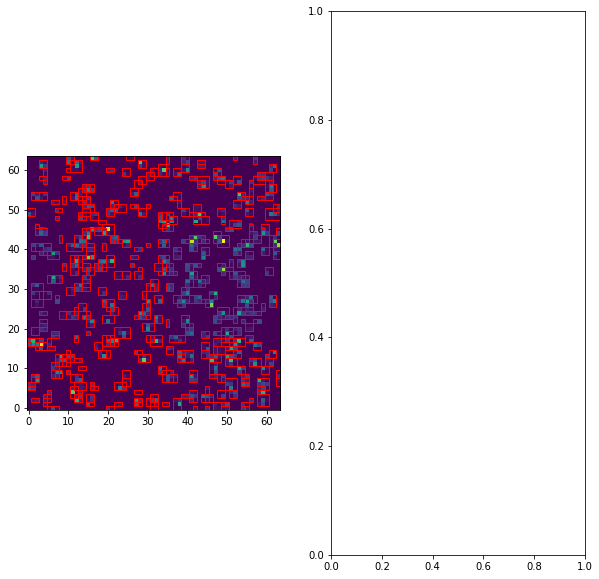

In [ ]:
import matplotlib.patches as patches
img = np.load(path+ f"{(filenumber-1):03}" +'_img.npz')
box = np.load(path+ f"{(filenumber-1):03}" +'_box.npz')

fig =  plt.figure(figsize=(10,10))
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(img['arr_100'], origin='lower')
for box in box['arr_100']:
  ymin, xmin, ymax, xmax = box
  rect = patches.Rectangle((xmin - 0.5, ymin - 0.5), xmax - xmin+1, ymax - ymin+1, linewidth=1, edgecolor='r',
                            facecolor='none')
  ax1.add_patch(rect)

# ax2.imshow(truth_all, origin='lower')
# for box in boxall:
#   ymin, xmin, ymax, xmax = box
#   ymax = ymax+1
#   xmax = xmax+1
#   ymin, xmin, ymax, xmax = ymin*2, xmin*2, ymax*2, xmax*2
#   rect = patches.Rectangle((xmin - 0.5, ymin - 0.5), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r',
#                             facecolor='none')
#   ax2.add_patch(rect)
plt.show()


Mostly, Sparsity>= 0.05 max count = 3

0.02>Sparsity>= 0.002 max count = 2

Sparsity < 0.002 max count = 1

# AUX functions


In [ ]:
def noisy(noise_typ,image): #defining a function to add noise to the images
   if noise_typ == "gauss":
      row,col,= image.shape
      mean = 0             #taken from sparse frames of celeritas histogram . mean = -0.17  .RMSD = 1.319
      var = 0.0001           #square of the standard deviation from sparse frames histogram
      sigma = var**0.5
      threshold = 8 #8ADU
      gauss = np.random.normal(mean,sigma,(row,col))     #thresholding instead of adding noise
      tnoisy = image + gauss                            #just making sure they're not exactly the same

      for x in range(row):                    #Noise thresholding so that only positive noise is added to the empty pixels
             for y in range(col):
                                                #each pixel should be an integer, not a floating point. Round each pixel after noise is added.
                 if tnoisy[x][y] < threshold:      #trying not to wipe out smaller contributions
                     tnoisy[x][y] = 0

      noisy = np.round(tnoisy) #+ gauss)    #adding noise after thresholding to recreate the image
      return noisy

In [ ]:
def deadcorr(raw):
  '''
  This function corrects the dead pixel within the dark reference frame.
  work for current dead pixel correction, interpolate from near position
  '''
  temp = raw
  temp[:,248] = 0.5*temp[:,247] + 0.5*temp[:,246]
  return temp